In [55]:
import sys
sys.path.append("../code/")
import numpy as np
import pandas as pd
from dataloader import APPLIANCE_ORDER, get_train_test
from tensor_custom_core import stf_4dim, stf_4dim_time
import torch
import torch.nn as nn
from torch.autograd import Variable
torch.manual_seed(0)
np.random.seed(0)

In [56]:
class CustomRNN(nn.Module):
    def __init__(self, cell_type, hidden_size, num_layers, bidirectional):
        super(CustomRNN, self).__init__()
        torch.manual_seed(0)

        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        if cell_type=="RNN":
            self.rnn = nn.RNN(input_size=3, hidden_size=hidden_size,
                   num_layers=num_layers, batch_first=True,
                   bidirectional=bidirectional)
        elif cell_type=="GRU":
            self.rnn = nn.GRU(input_size=3, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)
        else:
            self.rnn = nn.LSTM(input_size=3, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)

        self.linear = nn.Linear(hidden_size*self.num_directions, 1 )
        self.act = nn.ReLU()

    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.linear(pred)
        
        #pred = pred[:, :, 23:24]
        #pred = self.act(pred)
        #pred = torch.clamp(pred, min=0.)
        #pred = self.act(pred)
        #pred = torch.min(pred, x)
        return pred


num_folds = 5

if torch.cuda.is_available():
    cuda_av = True
else:
    cuda_av=False

In [57]:
c = CustomRNN('GRU',100, 1, False)
c

CustomRNN (
  (rnn): GRU(3, 100, batch_first=True)
  (linear): Linear (100 -> 1)
  (act): ReLU ()
)

In [62]:
fold_num = 0
num_folds = 5
cell_type="LSTM"
hidden_size = 150
lr = 1
bidirectional = True
appliance = "hvac"

In [63]:
from sklearn.preprocessing import OneHotEncoder

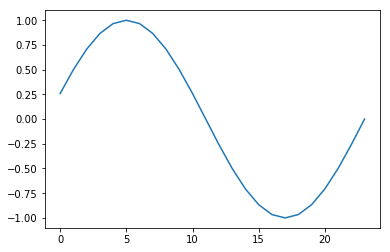

In [64]:
hours = np.arange(1, 25, 1)
np.sin(2 * np.pi * hours/24)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.sin(2 * np.pi * hours/24))

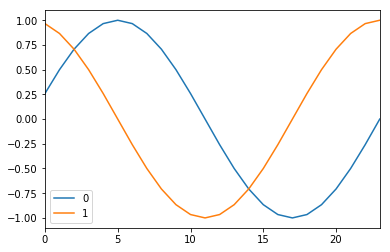

In [65]:
d=pd.DataFrame([np.sin(2 * np.pi * hours/24), np.cos(2 * np.pi * hours/24)]).T
d.plot()

In [66]:
torch.manual_seed(0)

appliance_num = APPLIANCE_ORDER.index(appliance)
train, test = get_train_test(num_folds=num_folds, fold_num=fold_num)

train_aggregate = train[:, 0, :, :].reshape(-1, 24, 1)
ta_max = train_aggregate.max()
ta_max = 1.
train_aggregate =train_aggregate/ta_max


test_aggregate = test[:, 0, :, :].reshape(-1, 24, 1)

train_appliance = (train[:, appliance_num, :, :].reshape(-1, 24, 1))/ta_max
test_appliance = test[:, appliance_num, :, :].reshape(-1, 24, 1)
   

In [67]:
train_aggregate_time = np.zeros((train_aggregate.shape[0], 24, 3))
for home in range(train_aggregate.shape[0]):
    temp = d.copy()
    temp['power'] = train_aggregate[home, :, :]
    train_aggregate_time[home, :, :] = temp.values
    

In [68]:
train_aggregate_time.shape

(6048, 24, 3)

In [69]:
loss_func = nn.L1Loss()
r = CustomRNN(cell_type, hidden_size, 1, bidirectional)

if cuda_av:
    r = r.cuda()
    loss_func = loss_func.cuda()

optimizer = torch.optim.Adam(r.parameters(), lr=lr)

In [70]:
num_iterations=100
for t in range(num_iterations):

    inp = Variable(torch.Tensor(train_aggregate_time), requires_grad=True)
    train_y = Variable(torch.Tensor(train_appliance))
    if cuda_av:
        inp = inp.cuda()
        train_y = train_y.cuda()
    pred = r(inp)
    print(pred.std().data[0], pred.mean().data[0])
    optimizer.zero_grad()
    loss = loss_func(pred, train_y)
    if t % 1 == 0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()
    
    

0.03279973566532135 -0.13300253450870514
0 892.6543579101562
4.550822734832764 137.57806396484375
1 810.634521484375
8.255387306213379 251.365966796875
2 753.2774658203125
12.318402290344238 371.33062744140625
3 707.1588134765625
16.043886184692383 483.8143310546875
4 677.9482421875
20.054183959960938 600.5756225585938
5 662.5895385742188
23.423282623291016 699.8963012695312
6 660.41162109375
26.11639976501465 777.473876953125
7 667.060791015625
28.625661849975586 822.5073852539062
8 676.8379516601562
28.800249099731445 844.6255493164062
9 677.7642211914062
39.110618591308594 795.4232788085938
10 683.8317260742188
31.85247802734375 730.880126953125
11 667.0079956054688
26.553138732910156 736.8369750976562
12 663.399658203125
27.742748260498047 733.3648071289062
13 663.8377685546875


KeyboardInterrupt: 

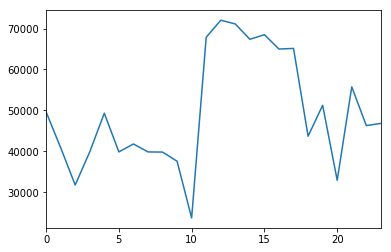

In [54]:
pd.Series(pred.data[0].numpy().flatten()*ta_max).plot()

In [23]:
pred

Variable containing:
( 0  ,.,.) = 
 -21.5008
 -21.5008
 -21.5008
    ⋮    
 -21.5008
 -21.5008
 -21.5008

( 1  ,.,.) = 
 -21.5008
 -21.5008
 -21.5008
    ⋮    
 -21.5008
 -21.5008
 -21.5008

( 2  ,.,.) = 
 -21.5008
 -21.5008
 -21.5008
    ⋮    
 -21.5008
 -21.5008
 -21.5008
 ... 

(6045,.,.) = 
 -21.5008
 -21.5008
 -21.5008
    ⋮    
 -21.5008
 -21.5008
 -21.5008

(6046,.,.) = 
 -21.5008
 -21.5008
 -21.5008
    ⋮    
 -21.5008
 -21.5008
 -21.5008

(6047,.,.) = 
 -21.5008
 -21.5008
 -21.5008
    ⋮    
 -21.5008
 -21.5008
 -21.5008
[torch.FloatTensor of size 6048x24x1]

In [ ]:
    test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
    test_y = Variable(torch.Tensor(test_appliance), requires_grad=False)
    if cuda_av:
        test_inp = test_inp.cuda()
    pred = r(test_inp)
    #pred[pred<0.] = 0.
    pred = torch.clamp(pred, min=0.)
    if cuda_av:
        prediction_fold = pred.cpu().data.numpy()
    else:
        prediction_fold = pred.data.numpy()

In [ ]:
gts = []
preds = []

def disagg_fold(fold_num, appliance, cell_type, hidden_size,
                num_layers, bidirectional, lr,
                num_iterations):
    torch.manual_seed(0)

    appliance_num = APPLIANCE_ORDER.index(appliance)
    train, test = get_train_test(num_folds=num_folds, fold_num=fold_num)
    train_aggregate = train[:, 0, :, :].reshape(-1, 24, 1)
    test_aggregate = test[:, 0, :, :].reshape(-1, 24, 1)

    train_appliance = train[:, appliance_num, :, :].reshape(-1, 24, 1)
    test_appliance = test[:, appliance_num, :, :].reshape(-1, 24, 1)
    gts.append(test_appliance.reshape(-1, 24))
    loss_func = nn.L1Loss()
    r = CustomRNN(cell_type, hidden_size, num_layers, bidirectional)

    if cuda_av:
        r = r.cuda()
        loss_func = loss_func.cuda()

    # Setting the params all to be non-negative
    #for param in r.parameters():
    #    param.data = param.data.abs()

    optimizer = torch.optim.Adam(r.parameters(), lr=lr)

    for t in range(num_iterations):

        inp = Variable(torch.Tensor(train_aggregate), requires_grad=True)
        train_y = Variable(torch.Tensor(train_appliance))
        if cuda_av:
            inp = inp.cuda()
            train_y = train_y.cuda()
        pred = r(inp)

        optimizer.zero_grad()
        loss = loss_func(pred, train_y)
        if t % 5 == 0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()

    test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
    test_y = Variable(torch.Tensor(test_appliance), requires_grad=False)
    if cuda_av:
        test_inp = test_inp.cuda()
    pred = r(test_inp)
    #pred[pred<0.] = 0.
    pred = torch.clamp(pred, min=0.)
    if cuda_av:
        prediction_fold = pred.cpu().data.numpy()
    else:
        prediction_fold = pred.data.numpy()
    return prediction_fold, test_appliance

def disagg(appliance, cell_type, hidden_size, num_layers, bidirectional, lr, num_iterations):
    from sklearn.metrics import mean_absolute_error
    preds = []
    gts = []
    for cur_fold in range(num_folds):
        pred, gt = disagg_fold(cur_fold, appliance, cell_type, hidden_size, num_layers
                               ,bidirectional, lr, num_iterations)

        preds.append(pred)
        gts.append(gt)
    return mean_absolute_error(np.concatenate(gts).flatten(), np.concatenate(preds).flatten())

appliance = "hvac"
cell_type="GRU" # One of GRU, LSTM, RNN
hidden_size=100 # [20, 50, 100, 150]
num_layers=1  # [1, 2, 3, 4]
bidirectional=False # True or False
lr =1 # 1e-3, 1e-2, 1e-1, 1, 2
num_iterations = 20 #200, 400, 600, 800

appliance, cell_type, hidden_size, num_layers, bidirectional, lr, num_iterations = sys.argv[1:]
hidden_size = int(hidden_size)
num_layers = int(num_layers)
lr = float(lr)
num_iterations = int(num_iterations)

p = disagg(appliance, cell_type, hidden_size, num_layers,
                bidirectional, lr, num_iterations)

import pickle
pickle.dump(p, open("./baseline/rnn-individual-baseline-result/rnn-individual-{}-{}-{}-{}-{}-{}-{}.pkl".format(appliance,
						cell_type, hidden_size, num_layers, bidirectional, lr, num_iterations), "wb"))